# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [676]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import os
import warnings

from scipy.special import exp10
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from category_encoders import TargetEncoder
from datetime import datetime
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from scipy.sparse import csr_matrix
from IPython.display import Markdown as md
from sklearn.utils import shuffle

In [488]:
warnings.filterwarnings('ignore')

In [489]:
pwd

'/Users/shivaallala/UcBerkeley_ML_AI_Program/Used-Car-dealership-cost-Prediction'

In [490]:
cars = pd.read_csv('/Users/shivaallala/UcBerkeley_ML_AI_Program/Used-Car-dealership-cost-Prediction/vehicles.csv')

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [491]:
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [492]:
cars.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [493]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

Data Problem Definition:
Our objective is to develop a predictive model that accurately estimates the price of used cars based on various attributes. This involves identifying the key features that significantly influence the pricing of used cars. The dataset contains information on 426,880 used cars, including attributes such as year, manufacturer, model, condition, odometer reading, and others. By analyzing these attributes, we aim to uncover patterns and relationships that can help us understand the factors driving car prices in the used car market.

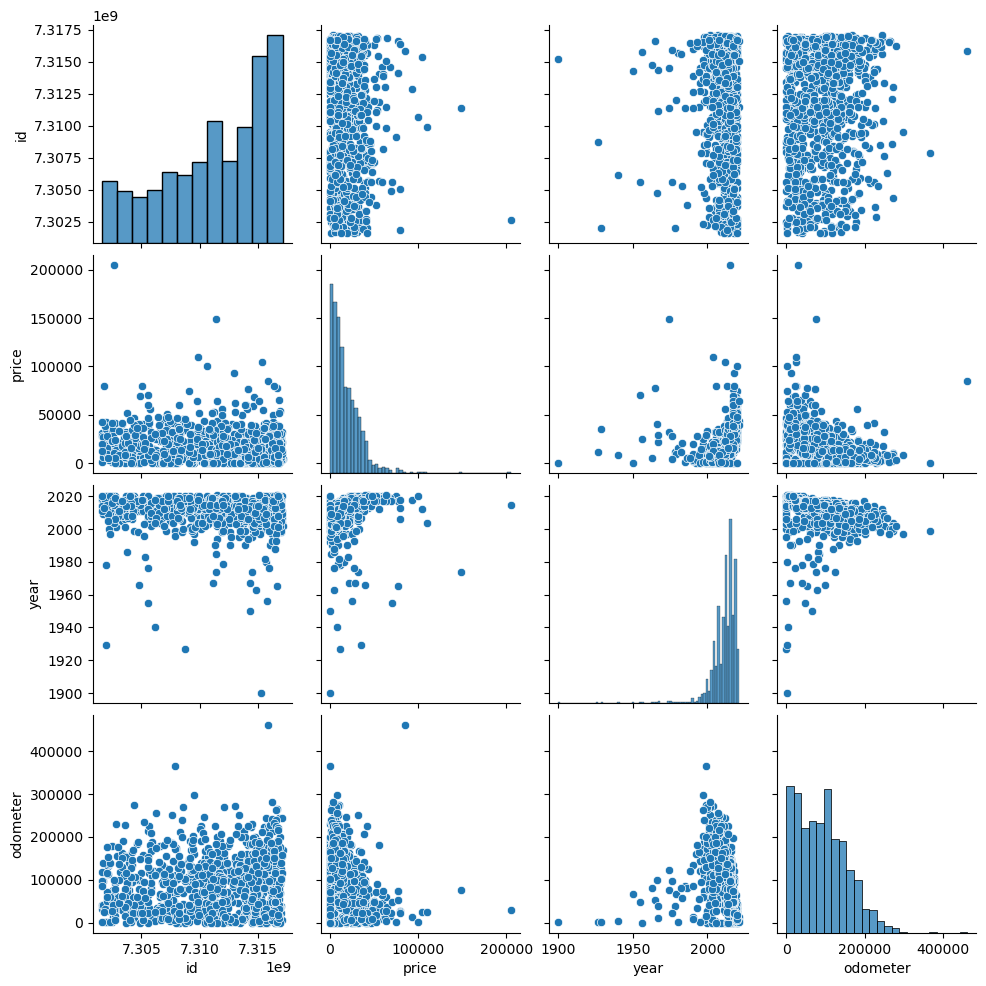

In [494]:
# Lets explore the numeric attribute with a pariplot
# Select a subset of columns for pair plot (excluding non-numeric columns)
numeric_cols = cars.select_dtypes(include=['int64', 'float64']).columns
subset_df = cars[numeric_cols]

# Create pair plot
sns.pairplot(subset_df.sample(n=1000))  # Subsampling for faster plotting (optional)
plt.show()

Cars Attributes value counts

In [495]:
# Lets observe the values counts of all categorical attributes
# Select non-numeric columns
non_numeric_cols = cars.select_dtypes(exclude=['int64', 'float64']).columns

# Loop through non-numeric columns and display value counts
for col in non_numeric_cols:
    print(f"Value counts for {col}:")
    print(cars[col].value_counts())
    print("\n")

Value counts for region:
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: region, Length: 404, dtype: int64


Value counts for manufacturer:
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427


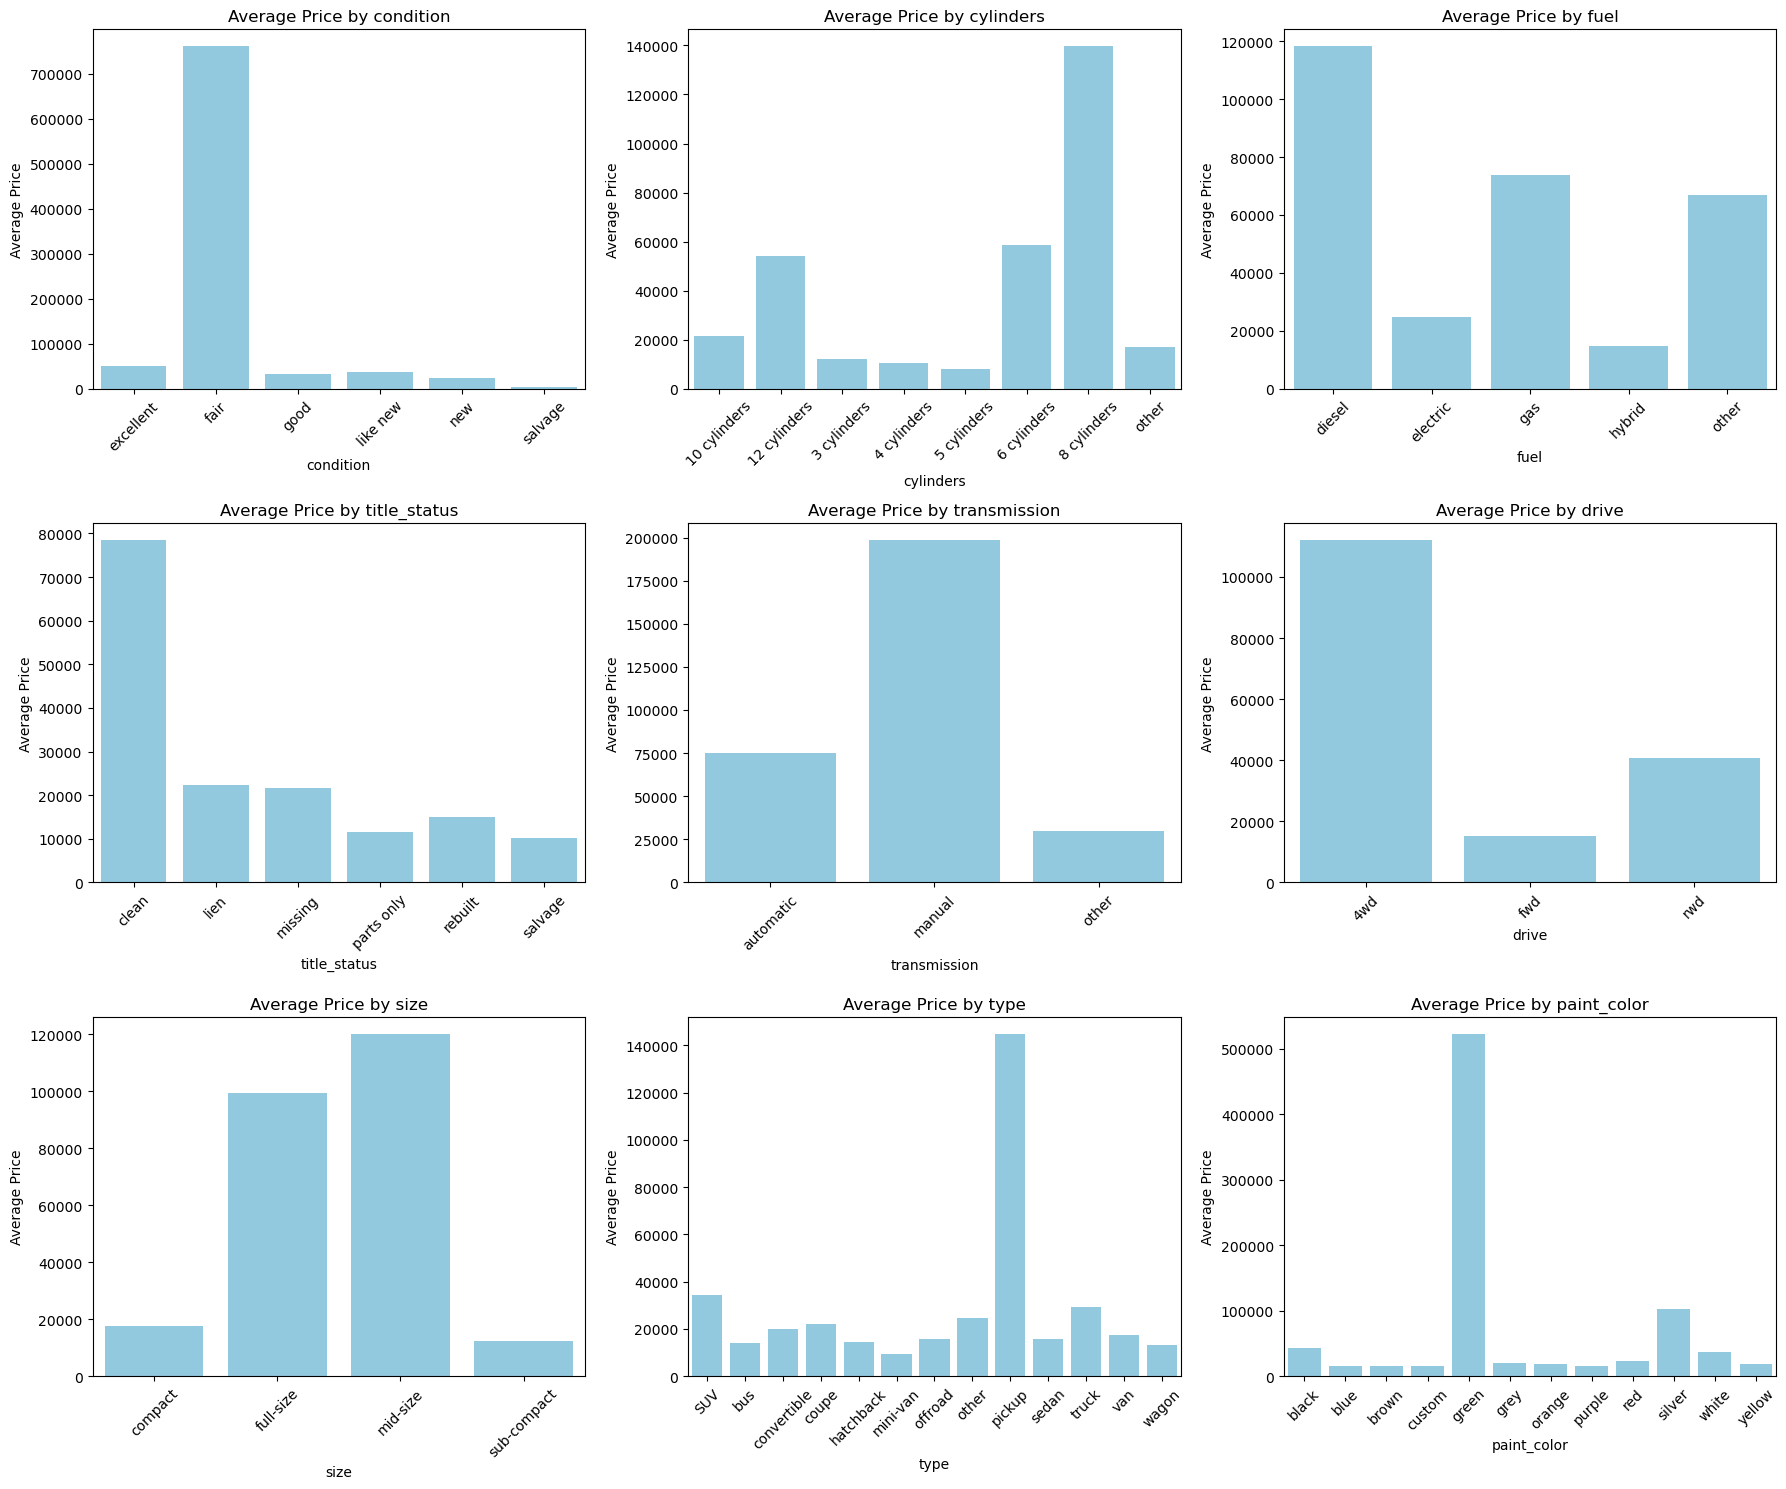

In [496]:
# Explore the average price of unique values in each attribute that has no more than 15 unique values

# Define a list of categorical attributes with no more than 15 unique values
attributes_to_explore = [col for col in cars.columns if cars[col].nunique() <= 15 and cars[col].dtype == 'object']

# Calculate the number of rows and columns for subplots
num_plots = len(attributes_to_explore)
num_cols = 3  # Number of columns for subplots
num_rows = -(-num_plots // num_cols)  # Ceiling division to calculate number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5*num_rows))
axes = axes.flatten()

# Loop through each attribute and calculate average price for each unique value
for i, attribute in enumerate(attributes_to_explore):
    # Group by the attribute and calculate the average price for each unique value
    avg_price_by_value = cars.groupby(attribute)['price'].mean().reset_index()
    
    # Plot average price for each unique value within the attribute
    sns.barplot(data=avg_price_by_value, x=attribute, y='price', color='skyblue', ax=axes[i])
    axes[i].set_title(f'Average Price by {attribute}')
    axes[i].set_xlabel(attribute)
    axes[i].set_ylabel('Average Price')
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplots
for j in range(num_plots, num_rows*num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

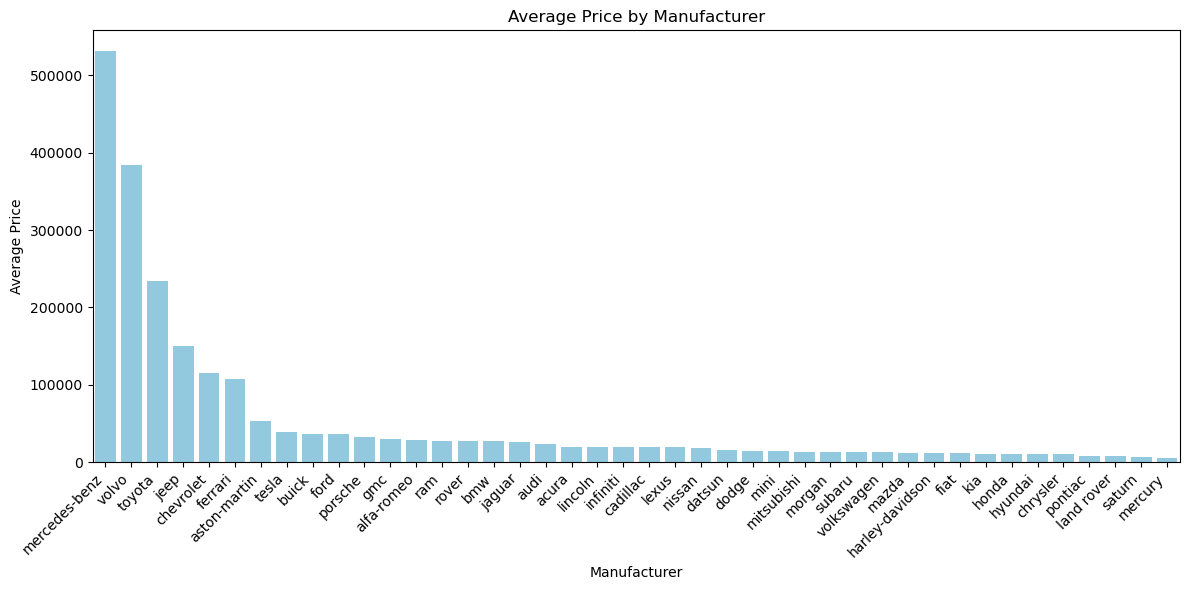

In [497]:
#Average price based on manufacturer
avg_price_by_manufacturer = cars.groupby('manufacturer')['price'].mean().reset_index()

# Sort manufacturers by average price
avg_price_by_manufacturer = avg_price_by_manufacturer.sort_values(by='price', ascending=False)

# Plot average price by manufacturer
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_price_by_manufacturer, x='manufacturer', y='price', color='skyblue')
plt.title('Average Price by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

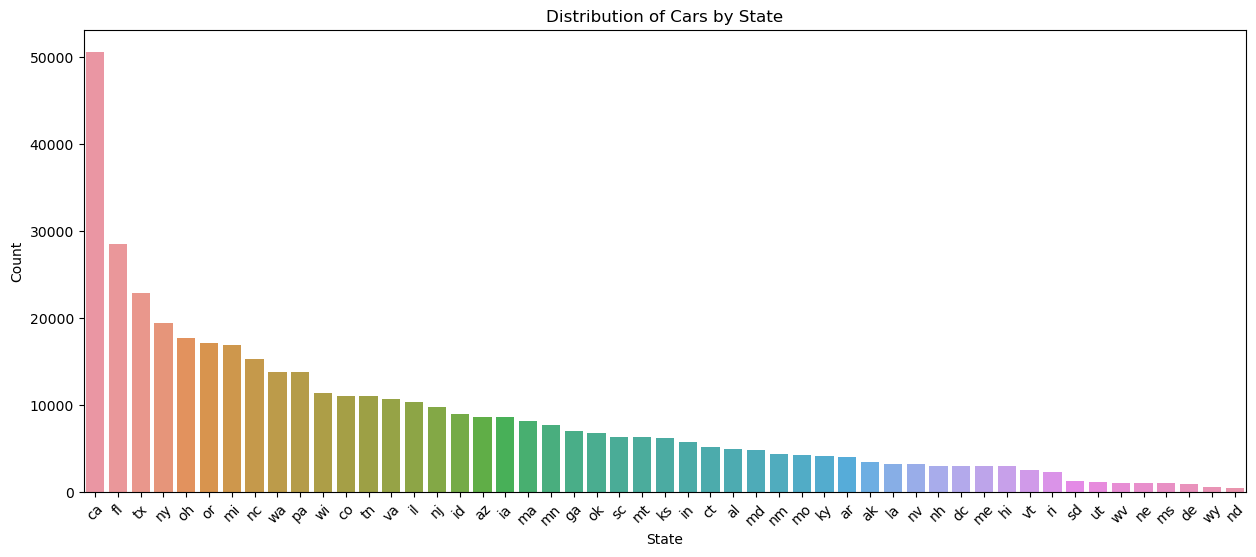

In [498]:
#State attribute distribution obervation
plt.figure(figsize=(15,6))
sns.countplot(data = cars, x='state', order=cars['state'].value_counts().index)
plt.title("Distribution of Cars by State")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Imbalanced Distribution: Attributes with highly imbalanced distributions, where one or a few categories dominate the majority of the data, may not contribute much to the model's performance. For example, the "state" attribute has highly imbalanced distributions, with some states having significantly more observations than others. Region attribute plays a similar role as it poses insigificant relevance to the analysis or prediction. Also evaluating 'region' attribute's cardinality expresses the high degree of unique values, approximately 404 unique values. Based on this rationale, it is deamed appropreiate to remove 'region' as well. 

Here lets observe any extreme outlier for numerical data. This includes Price and odometer.

In [499]:
print("average price of car: " + str(cars['price'].mean()))
print("max price of car: " + str(cars['price'].max()))

average price of car: 75199.0331873126
max price of car: 3736928711


In [500]:
print("average odometer of car: " + str(cars['odometer'].mean()))
print("max odometer of car: " + str(cars['odometer'].max()))

average odometer of car: 98043.33144290854
max odometer of car: 10000000.0


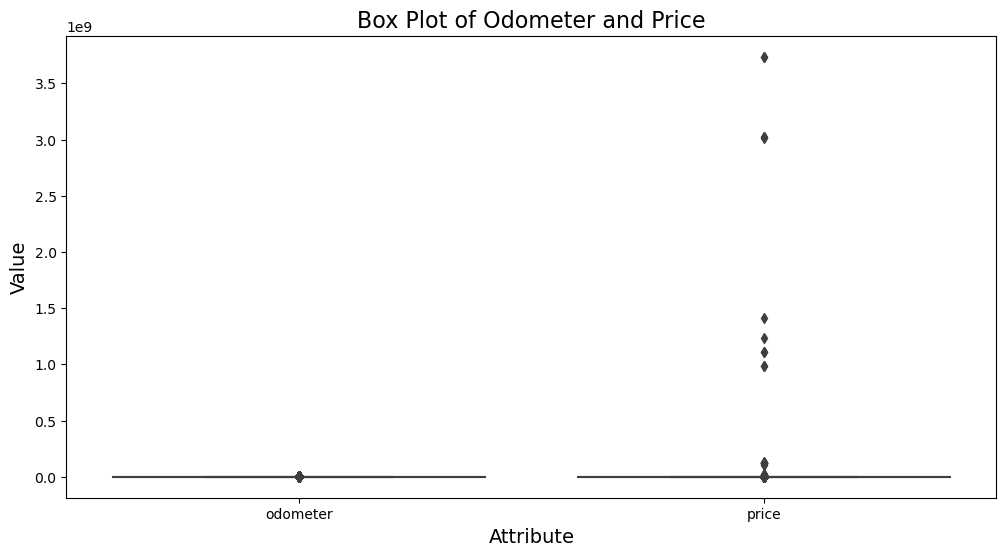

In [501]:
# Create a figure and axis object
plt.figure(figsize=(12, 6))

# Plot box plots for odometer and price
sns.boxplot(data=cars[['odometer', 'price']])

# Add labels and title
plt.xlabel('Attribute', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Box Plot of Odometer and Price', fontsize=16)

# Show the plot
plt.show()

In [502]:
cars[cars['price'] == 0].loc[:,'price']

10        0
11        0
12        0
13        0
14        0
         ..
426764    0
426812    0
426832    0
426836    0
426868    0
Name: price, Length: 32895, dtype: int64

In [503]:
cars[cars['odometer'] == 0].loc[:,'odometer']

538       0.0
563       0.0
694       0.0
889       0.0
985       0.0
         ... 
425904    0.0
425905    0.0
426002    0.0
426518    0.0
426638    0.0
Name: odometer, Length: 1965, dtype: float64

Looks like there are 30,000 entries where the car price is 0 regardless of the integrity and authentisity of other features. Odometer has 1965 0 entries.

**Hypothesis**

Upon analyzing the dataset column by column, several observations and strategies for data preprocessing emerge:

Dropping attributes:

- ID: We can safely drop this column as it serves as an index and does not provide meaningful information.
- VIN: Since it serves as a unique identifier, we can safely drop this column.

Filling impurities: 

- Year: We can replace missing values with the most frequent year observed in the dataset.
- Manufacturer: Despite some null values, we can impute them with the most frequently observed manufacturer.
- Cylinders: Convert this column to numerical and replace missing values with the most frequent value, considering the risk of imputing nearly half of null values.
- Drive: While important, this feature has a high percentage of null values. We'll impute them with the most frequent value, ensuring it doesn't exceed 50% of the total dataset.
- State and Region: These are categorical variables without null values, so no action is needed.
- Transmission, Fuel, Title Status, Condition: For these categorical variables, we will replace missing values with the most frequently occurring value.
- Type and Paint Color: We will replace missing values with the most frequently occurring value for each.
- Size: With over 50% null values, this column may not provide useful information and could be dropped after further processing.
- Model: With a significant number of unique categorical values, we may need to reduce categories or address null values later.
Extensive data preparation:

- Price: As the target variable, some entries have a value of 0, which we will replace with the mean value. Although, certain extreme outliers could impact the mean, which will need to removed before calculating mean.
- Odometer: Missing values can be imputed by averaging the odometer readings of all vehicles. Although, certain extreme outliers could impact the mean, which will need to removed before calculating mean.

Additionally, we'll remove records with incomplete data, retaining only those with meaningful information beyond just the price, state, and region.

### Data Preparation
After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling. Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with sklearn.

In [623]:
#Setting up our Clean data cars_cleaned
cars_cleaned = cars.copy()

In [624]:
print("Odometer extreme values average: " +str(cars_cleaned[cars_cleaned['odometer'] >= 500000].loc[:,'odometer'].mean()))
cars_cleaned[cars_cleaned['odometer'] >= 500000].loc[:,'odometer'].head(3)

Odometer extreme values average: 2112991.699929726


280     999999.0
455    9999999.0
562    2222222.0
Name: odometer, dtype: float64

In [625]:
print("Price extreme values average: " +str(cars_cleaned[cars_cleaned['price'] >= 300000].loc[:,'price'].mean()))
cars_cleaned[cars_cleaned['price'] >= 500000].loc[:,'price'].head(3)

Price extreme values average: 320240830.09090906


280      987654321
1838      99999999
26075      1111111
Name: price, dtype: int64

In [626]:
# Z-score method to remove outliers
# Calculate Z-scores for prices
cars_cleaned['z_score'] = stats.zscore(cars_cleaned['price'])

# Find indices of rows with Z-scores greater than 0.1
zscores = cars_cleaned.loc[(cars_cleaned['z_score'] > 0.1)].index

# Drop rows with high Z-scores
cars_cleaned = cars_cleaned.drop(zscores)

# Drop the temporary z_score column
cars_cleaned = cars_cleaned.drop(['z_score'], axis=1)

# IQR method to remove outliers
# Calculate quartiles and interquartile range for prices
q1 = cars_cleaned['price'].quantile(0.25)
q3 = cars_cleaned['price'].quantile(0.75)
iqr = q3 - q1

# Calculate lower and upper limits for outliers
low_lim = q1 - 0.2 * iqr
upper_lim = q3 + 2.5 * iqr

# Find indices of rows with prices outside the IQR limits
iqr_index = cars_cleaned[(cars_cleaned['price'] < low_lim) | (cars_cleaned['price'] > upper_lim)].index

# Drop rows with prices outside the IQR limits
cars_cleaned = cars_cleaned.drop(iqr_index)

# Now the DataFrame 'cars_cleaned' contains data without outliers removed using Z-score and IQR methods.

In [627]:
#Lets remove the unwanted features discussed above
cars_cleaned = cars_cleaned.drop(['VIN','id'], axis=1)
cars_cleaned = cars_cleaned.reset_index(drop=True)

In [628]:
# Imputing missing data
imputer_trans = make_column_transformer(
    (SimpleImputer(missing_values=np.nan, strategy='mean'), ['odometer']),
    (SimpleImputer(missing_values=np.nan, strategy='most_frequent'), ['year', 'cylinders'])
)

# Replace non-numeric values in 'cylinders' column with NaN
cars_cleaned['cylinders'] = cars_cleaned['cylinders'].str.replace(' cylinders', '').str.replace('other', '6').str.strip()
cars_cleaned['cylinders'] = pd.to_numeric(cars_cleaned['cylinders'], errors='coerce')

imp_features = pd.DataFrame(imputer_trans.fit_transform(cars_cleaned), columns=['odometer', 'year', 'cylinders'])

cars_cleaned['odometer'] = imp_features['odometer'].astype('int64')
cars_cleaned.drop(cars_cleaned.loc[cars_cleaned['odometer'] > 500000].index, inplace=True)
cars_cleaned['year'] = imp_features['year'].astype('int32')
cars_cleaned['cylinders'] = imp_features['cylinders'].astype('int32')

columns_to_fillna = ['transmission', 'fuel', 'title_status', 'manufacturer', 'type', 'paint_color', 'drive', 'condition', 'size','model']

for column in columns_to_fillna:
    cars_cleaned[column] = cars_cleaned[column].fillna(cars_cleaned[column].mode()[0])

In [629]:
# Cleaning the 'model' feature

# Define a function to split the model string based on a separator
def split_model(string, sep):
    # Split the string into tokens using the separator
    tokens = string.split(sep)
    res = ''
    # If there's only one token, return it as is
    if len(tokens) == 1:
        res = tokens[0]
    # If there are multiple tokens, concatenate the first two tokens
    elif len(tokens) >= 2:
        res = f'{tokens[0]} {tokens[1]}'
    return res

# Remove models with fewer than 50 occurrences from the dataset
cars_cleaned = cars_cleaned[~cars_cleaned['model'].isin(cars_cleaned['model'].value_counts()[cars_cleaned['model'].value_counts() < 50].index)]

# Split the models based on space (' ') and forward slash ('/') separators
cars_cleaned['model'] = cars_cleaned['model'].astype(str).apply(lambda x: split_model(x, ' '))
cars_cleaned['model'] = cars_cleaned['model'].astype(str).apply(lambda x: split_model(x, '/'))

In [630]:
cars_cleaned = cars_cleaned.dropna()

In [631]:
cars_cleaned

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,prescott,6000,2018,ford,f-150,good,6,gas,97340,clean,automatic,4wd,full-size,sedan,white,az
1,fayetteville,11900,2018,ford,f-150,good,6,gas,97340,clean,automatic,4wd,full-size,sedan,white,ar
2,florida keys,21000,2018,ford,f-150,good,6,gas,97340,clean,automatic,4wd,full-size,sedan,white,fl
3,greensboro,4900,2018,ford,f-150,good,6,gas,97340,clean,automatic,4wd,full-size,sedan,white,nc
4,hudson valley,15995,2018,ford,f-150,good,6,gas,97340,clean,automatic,4wd,full-size,sedan,white,ny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373432,wyoming,32590,2020,mercedes-benz,c-class c,good,6,gas,19059,clean,other,rwd,full-size,sedan,white,wy
373434,wyoming,33590,2018,lexus,gs 350,good,6,gas,30814,clean,automatic,rwd,full-size,sedan,white,wy
373436,wyoming,30590,2020,volvo,s60 t5,good,6,gas,12029,clean,other,fwd,full-size,sedan,red,wy
373437,wyoming,34990,2020,cadillac,xt4 sport,good,6,diesel,4174,clean,other,4wd,full-size,hatchback,white,wy


In [632]:
# Count the number of duplicate and non-duplicate rows in the cars_cleaned dataset
duplicate_count = cars_cleaned.duplicated().value_counts()

# Calculate the percentage of duplicate and non-duplicate rows
duplicates_per = (duplicate_count[True] / len(cars_cleaned)) * 100
no_duplicates_per = (duplicate_count[False] / len(cars_cleaned)) * 100

# Print the results
print(f"No Duplicates: {duplicate_count[False]} ({no_duplicates_per:.2f}%)")
print(f"Duplicates: {duplicate_count[True]} ({duplicates_per:.2f}%)")

No Duplicates: 231239 (87.31%)
Duplicates: 33608 (12.69%)


In [633]:
# Drop the duplicates
cars_cleaned = cars_cleaned.drop_duplicates()

In [634]:
cars_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231239 entries, 0 to 373438
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        231239 non-null  object
 1   price         231239 non-null  int64 
 2   year          231239 non-null  int32 
 3   manufacturer  231239 non-null  object
 4   model         231239 non-null  object
 5   condition     231239 non-null  object
 6   cylinders     231239 non-null  int32 
 7   fuel          231239 non-null  object
 8   odometer      231239 non-null  int64 
 9   title_status  231239 non-null  object
 10  transmission  231239 non-null  object
 11  drive         231239 non-null  object
 12  size          231239 non-null  object
 13  type          231239 non-null  object
 14  paint_color   231239 non-null  object
 15  state         231239 non-null  object
dtypes: int32(2), int64(2), object(12)
memory usage: 28.2+ MB


Cars Cleaned Correlation matrix to understand the relationship between variables in a dataset.

<Axes: >

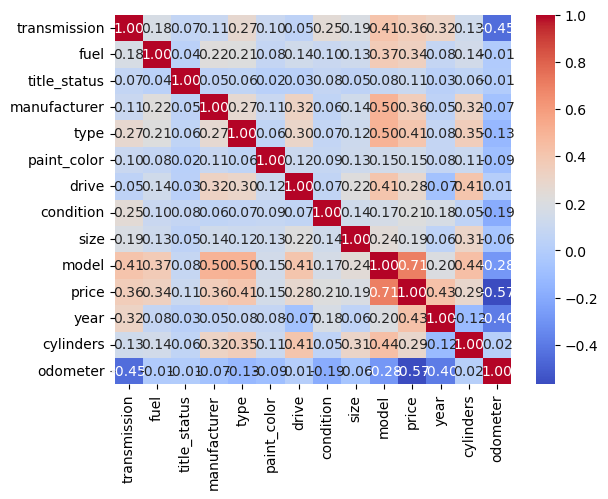

In [635]:

# Initialize the TargetEncoder
encoder = TargetEncoder()

# Encode categorical variables
categorical_cols = ['transmission', 'fuel', 'title_status', 'manufacturer', 'type', 'paint_color', 'drive', 'condition', 'size','model']
encoded_cols = encoder.fit_transform(cars_cleaned[categorical_cols], cars_cleaned['price'])

# Combine encoded categorical variables with numerical variables
encoded_df = pd.concat([encoded_cols, cars_cleaned.drop(columns=categorical_cols)], axis=1)

# Calculate the correlation matrix
correlation_matrix = encoded_df.corr()

# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

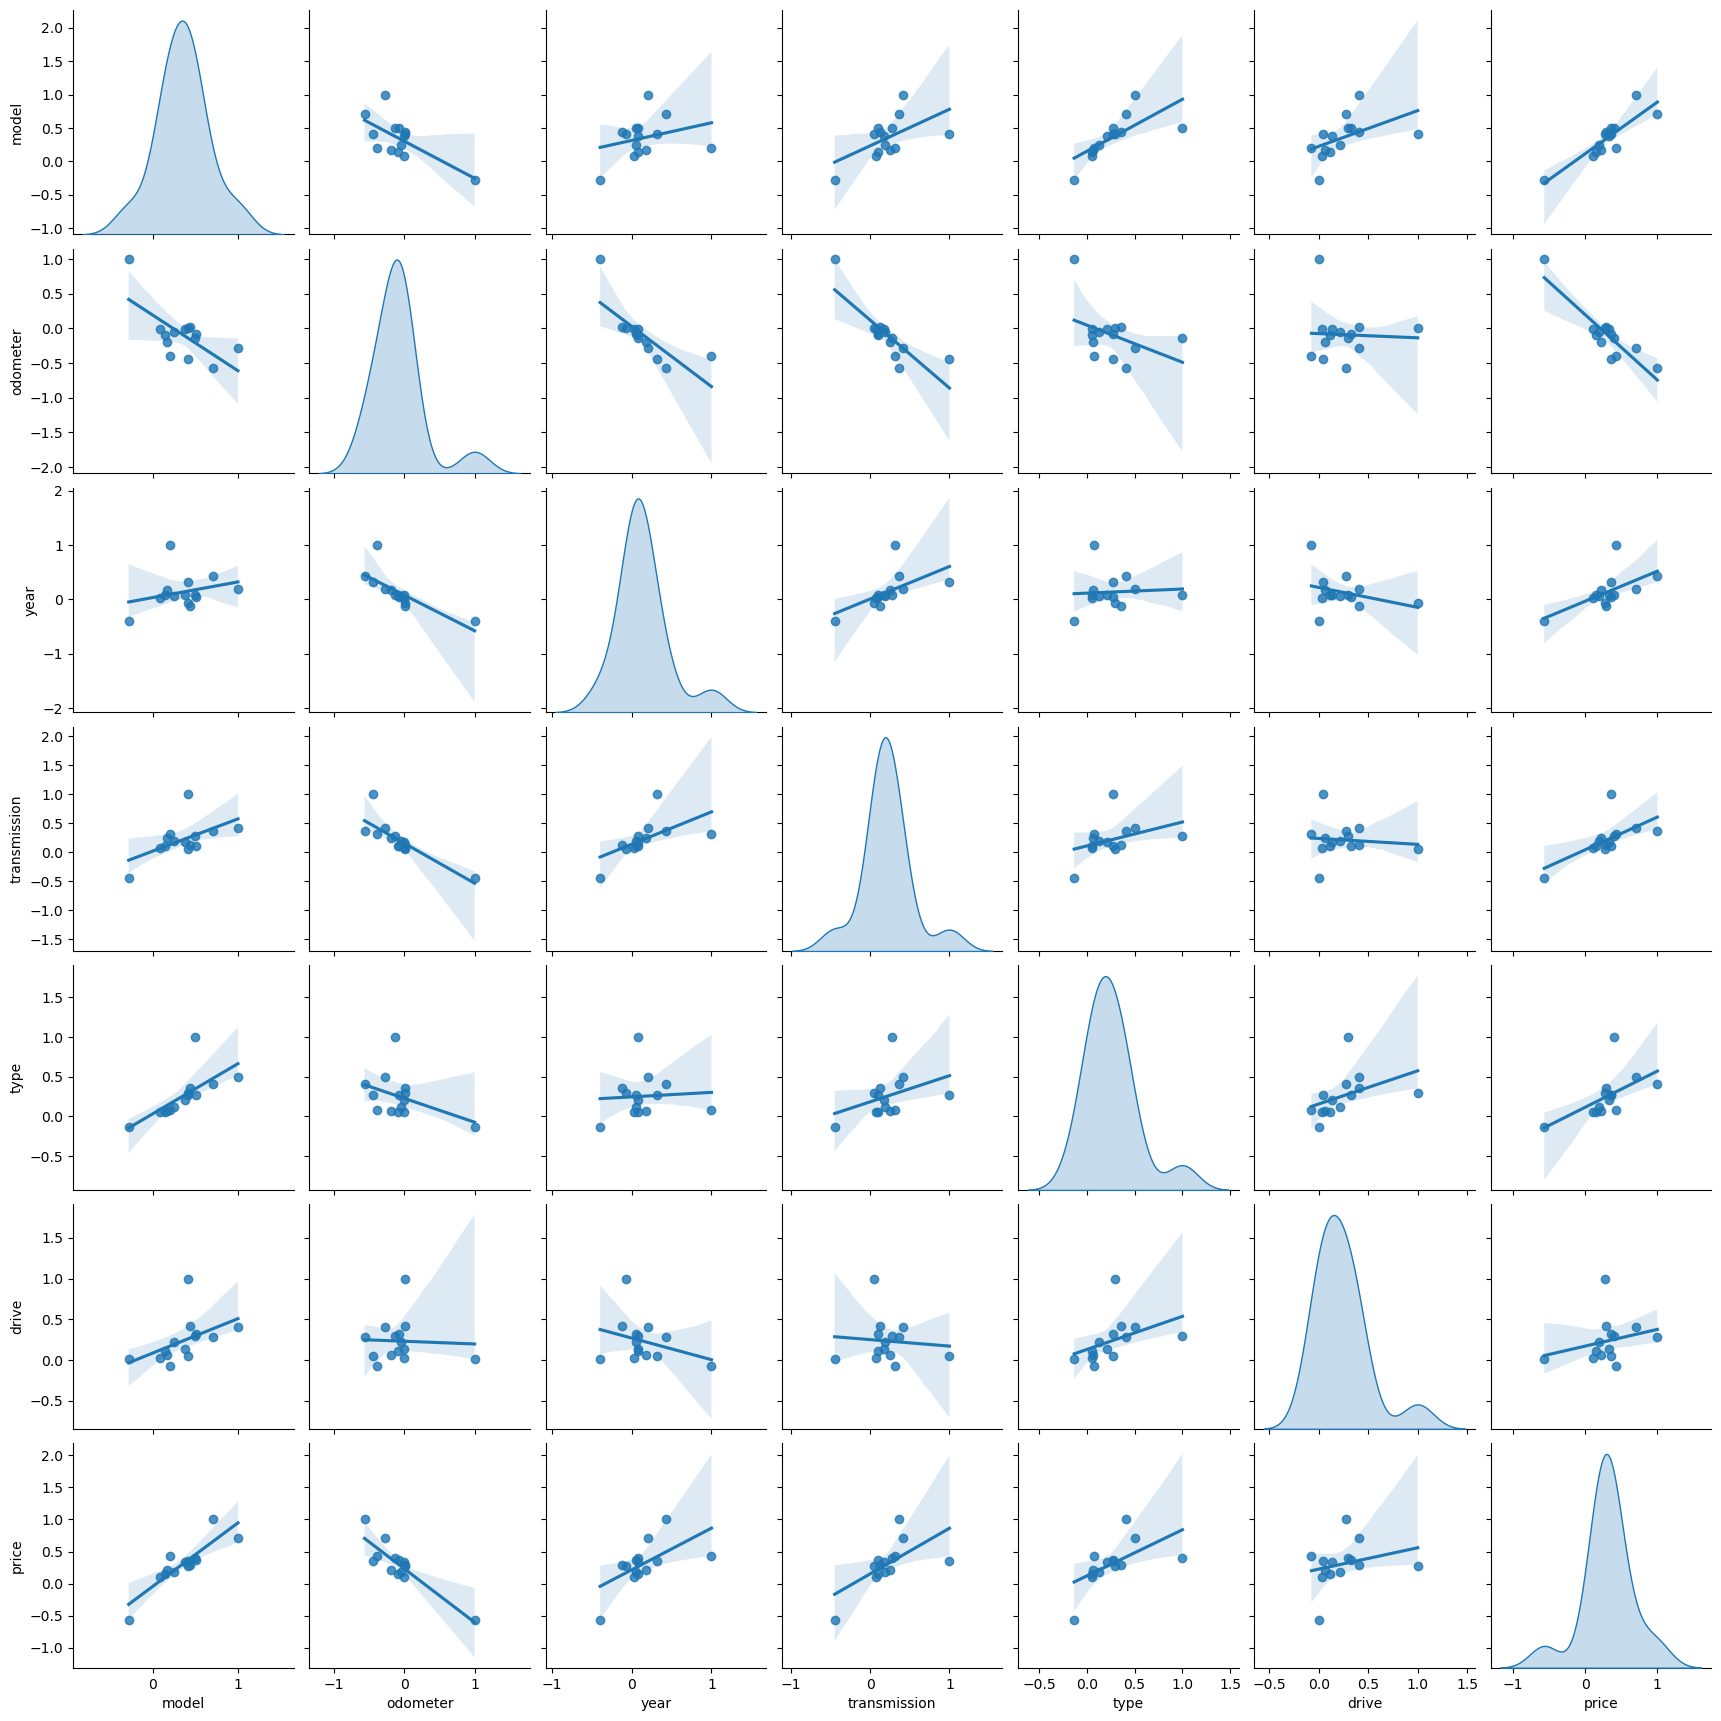

In [636]:
sns.pairplot(correlation_matrix[['model', 'odometer', 'year', 'transmission','type','drive', 'price']],kind="reg", diag_kind="kde")

**Evaluation:**

After performing data imputation, most missing values were filled with the most frequent value. However, for the 'odometer' feature, an average value was used to address null values, considering its continuous nature.

Following data cleaning procedures, a significant proportion of duplicate values were identified and removed. Approximately 13% of the records were found to be duplicated, even after handling missing values through imputation. Outliers with exceptionally high values were detected and removed using the Z-score method, along with extreme values identified through the Interquartile Range (IQR) technique. This step aimed to enhance the dataset's robustness by mitigating the impact of extreme values on subsequent analyses.

Regarding the 'model' feature, numerous categories exhibited names with excessively long texts. To streamline and simplify the categories, names exceeding two words were truncated to retain only the first two words. Additionally, categories with fewer than 50 records were excluded to focus on more prevalent and representative model types. The correlation analysis revealed several noteworthy relationships among the features. Notably, a strong positive correlation was observed between the 'price' and 'model' features, indicating that variations in the model are closely associated with changes in price. Conversely, a negative correlation was identified between 'odometer' and 'price,' suggesting that higher odometer readings correspond to lower vehicle prices, reflecting the expected depreciation with increased mileage.

Furthermore, a negative correlation between 'odometer' and 'transmission' implies that higher odometer readings are linked to greater transmission wear, potentially influencing the vehicle's market value. Lastly, a positive correlation between 'region' and 'state' features was noted, as both represent location-based attributes, demonstrating a logical relationship between geographical indicators within the dataset.

### Preparing dataset for modeling

Split and ready training and Test data for modeling, testing, scoring.

In [637]:
# Let add another attribute that holds the log of the target varible (price) price_log to improve skewness of price
cars_cleaned['price_log'] = np.log(cars_cleaned['price'])
cars_cleaned[['price', 'price_log']].head()

,price,price_log
0,6000,8.699515
1,11900,9.384294
2,21000,9.952278
3,4900,8.496990
4,15995,9.680031


Encoding Categorical Features

In [638]:
# New dataframe to store encoded version of the data set
cars_encoded = cars_cleaned.copy()

In [639]:
# Encoding the categorical features
tn = TargetEncoder()
encoded_df = tn.fit_transform(cars_encoded[['manufacturer', 'model', 'size','cylinders', 'fuel', 'state', 'region', 'title_status',
                                  'transmission', 'drive', 'type', 'paint_color']], cars_encoded['price'])
                              

In [640]:
#Replacing old categorical features
cars_encoded = cars_encoded.drop(['manufacturer', 'model', 'size','cylinders', 'fuel', 'state', 'region', 'title_status',
                                  'transmission', 'drive', 'type', 'paint_color'], axis = 1)
cars_encoded = pd.concat([cars_encoded, encoded_df], axis = 1)
cars_encoded.shape

(231239, 17)

In [641]:
#Converting 'condition' to numeric scale (from 1=salvage to 6=new)
cars_encoded["condition"].replace({"new" : 6, "like new" : 5, "excellent" : 4, "good" : 3, "fair" : 2, "salvage" : 1}, inplace = True)
cars_encoded["condition"] = cars_encoded["condition"].astype(int)

In [642]:
cars_encoded.head()

,price,year,condition,odometer,price_log,manufacturer,model,size,cylinders,fuel,state,region,title_status,transmission,drive,type,paint_color
0,6000,2018,3,97340,8.699515,20682.705043,20796.41861,20113.064369,6,17458.803278,18939.860492,22349.083538,19375.278982,17080.483674,21263.986213,14863.320934,19747.866368
1,11900,2018,3,97340,9.384294,20682.705043,20796.41861,20113.064369,6,17458.803278,22270.961340,20252.787159,19375.278982,17080.483674,21263.986213,14863.320934,19747.866368
2,21000,2018,3,97340,9.952278,20682.705043,20796.41861,20113.064369,6,17458.803278,18994.276864,26031.657199,19375.278982,17080.483674,21263.986213,14863.320934,19747.866368
3,4900,2018,3,97340,8.496990,20682.705043,20796.41861,20113.064369,6,17458.803278,20111.796569,21066.261290,19375.278982,17080.483674,21263.986213,14863.320934,19747.866368
4,15995,2018,3,97340,9.680031,20682.705043,20796.41861,20113.064369,6,17458.803278,18878.034607,16678.204409,19375.278982,17080.483674,21263.986213,14863.320934,19747.866368


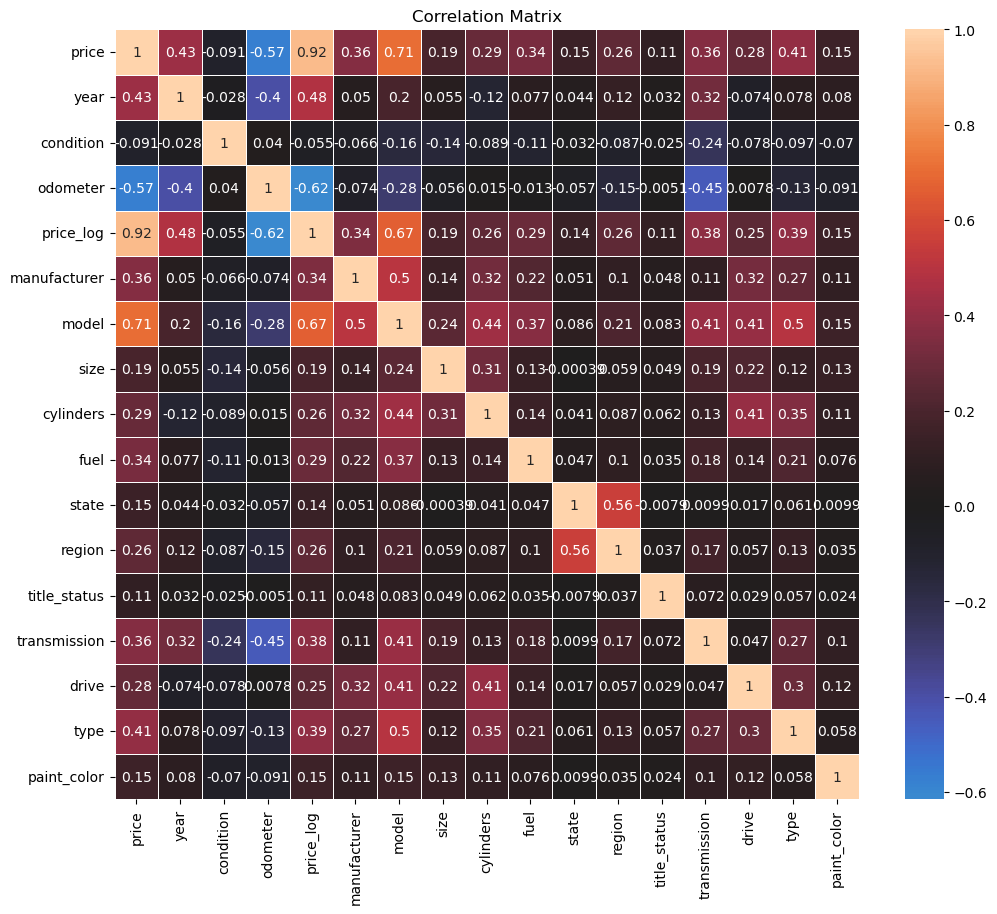

In [643]:
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cars_encoded.corr(), center = 0, linewidth = .5, annot = True).set(title='Correlation Matrix');

The correlation matrix, represented visually through a heatmap, provides valuable insights into the relationships between different variables, affirming and shedding light on initial assumptions.

With respect to Price of the cars

The most significant correlations emerge with attributes like year of manufacture, odometer reading, specific models, and vehicle types. Surprisingly, notable correlations also exist with technical aspects such as cylinder count, transmission type, and drive configuration. Conversely, features like condition, fuel type, and title status demonstrate weaker correlations, consistent with the expectation that most vehicles are typically in good condition, fueled by gas, and hold a clean title.

Furthermore, additional noteworthy correlations surface between year and odometer readings, which aligns with the intuitive expectation of odometer values increasing over time. Likewise, associations between model and vehicle type, manufacturer and model, as well as technical attributes and vehicle types, offer deeper insights into the interplay between these characteristics.

In summary, the correlation analysis not only confirms certain initial hypotheses but also unveils nuanced relationships between variables, contributing to a more comprehensive understanding of the factors influencing vehicle prices.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models. Here, you should build a number of different regression models with the price as the target. In building your models, you should explore different parameters and be sure to cross-validate your findings.


In [644]:
X = cars_encoded.drop('price', axis = 1)
y_log = cars_encoded['price_log']
y = cars_encoded['price']

### Linear Regression Model on Log(Price)

In [645]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, random_state = 42, test_size = .3)

In [646]:
# Training linear model
lin_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)

In [647]:
mse = mean_squared_error(lin_reg.predict(X_test), y_test)
print(f"MSE of Linear Regression model is {np.round(mse, 6)}")
print(f"R2 score of Linear Regression model is {np.round(r2_score(y_test, lin_reg.predict(X_test)), 6)}")

MSE of Linear Regression model is 0.0
R2 score of Linear Regression model is 1.0


When assessing the performance of a model, I employ two key metrics: Mean Squared Error (MSE) and R-squared (R^2). MSE is a widely utilized metric for evaluating model predictions due to its robustness in penalizing outliers. It quantifies the average squared difference between predicted and actual values, offering insight into the model's accuracy.

On the other hand, R-squared serves as a measure of how much of the variance in the dependent variable (price) is explained by the regression model. It ranges from 0 to 1, where a higher value indicates that a larger proportion of the variance is captured by the model, suggesting a better fit. By employing both MSE and R-squared, I gain a comprehensive understanding of the model's predictive performance, accounting for both accuracy and explanatory power.

In [648]:
y_preds = lin_reg.predict(X_train)
y_preds

array([10.16546713, 10.16546713,  9.04782144, ...,  9.09380656,
       10.36059589,  9.35010231])

In [649]:
df_predictions = pd.DataFrame({'Actual Prices': y_train, 'Predicted Prices': y_preds})

# Display the DataFrame
print(df_predictions)

        Actual Prices  Predicted Prices
188219      10.165467         10.165467
8030        10.165467         10.165467
245154       9.047821          9.047821
327855       9.903037          9.903037
341871       8.698681          8.698681
...               ...               ...
193543      10.391761         10.391761
170644       8.268732          8.268732
214228       9.093807          9.093807
237500      10.360596         10.360596
196502       9.350102          9.350102

[161867 rows x 2 columns]


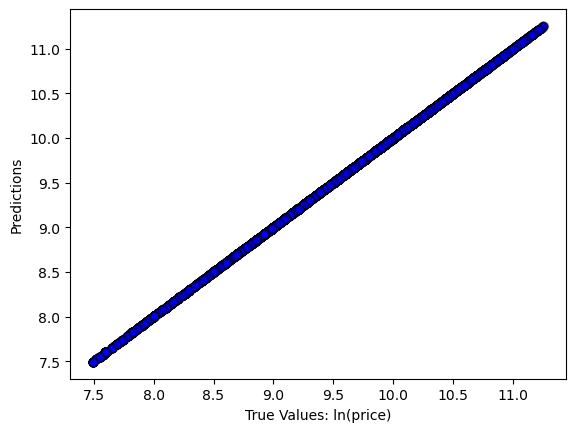

In [650]:
plt.scatter(y_test, lin_reg.predict(X_test), c='blue', alpha=0.2, edgecolors='black')

plt.xlabel('True Values: ln(price)')
plt.ylabel('Predictions')

plt.show()

### Linear Regression Model on Real Price 

In [651]:
# Training using real values of price instead of the log.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .3)

In [652]:
# Training linear model
lin_reg2 = LinearRegression(fit_intercept = True).fit(X_train, y_train)

In [653]:
mse = mean_squared_error(lin_reg2.predict(X_test), y_test)
print(f"MSE of Linear Regression model is {np.round(mse, 6)}")
print(f"R2 score of Linear Regression model is {np.round(r2_score(y_test, lin_reg2.predict(X_test)), 6)}")

MSE of Linear Regression model is 22869373.381521
R2 score of Linear Regression model is 0.871346


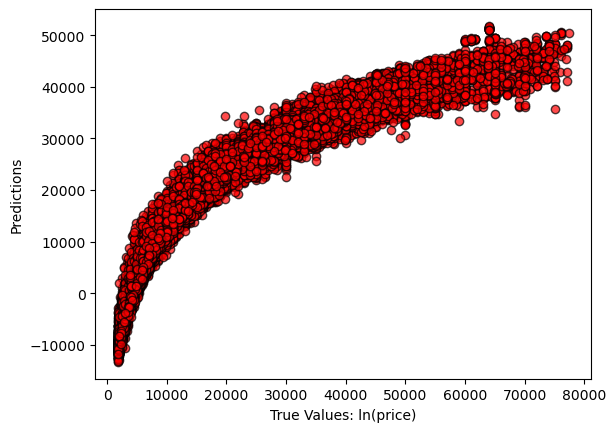

In [654]:
plt.scatter(y_test, lin_reg2.predict(X_test), c='red', alpha=0.7, edgecolors='black')

plt.xlabel('True Values: ln(price)')
plt.ylabel('Predictions')

plt.show()

### Linear Regression Model with Polynomial Features

To enhance the initial Linear Regression model, I integrate a polynomial transformer, enabling the exploration of nonlinear relationships between features and the target variable. To determine the optimal polynomial degree for the model, I implement a Simple Cross Validation process. This involves iterating through polynomial complexities ranging from 1 to 5. For each complexity, a model is constructed with the specified degree, and the one yielding the lowest test mean squared error is selected. This iterative approach allows for the identification of the most suitable polynomial degree, thus refining the model's predictive performance.

In [655]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .3)

In [656]:
def simple_cross_validation(X_train, y_train, X_test, y_test):
    best_pipe = None
    best_mse = np.inf

    for degree in range(1, 4):
        pipe = Pipeline([
            ("poly", PolynomialFeatures(degree = degree, include_bias = False)),
            ("scaler", StandardScaler()),
            ("linRegr", LinearRegression())
        ])

        pipe.fit(X_train, y_train)
        
        test_mse = mean_squared_error(pipe.predict(X_test), y_test)

        if test_mse < best_mse:
            best_mse = test_mse
            best_pipe = pipe
            
    return best_pipe

In [657]:
best_lr_model = simple_cross_validation(X_train, y_train, X_test, y_test)
best_lr_model.get_params()

{'memory': None,
 'steps': [('poly', PolynomialFeatures(degree=3, include_bias=False)),
  ('scaler', StandardScaler()),
  ('linRegr', LinearRegression())],
 'verbose': False,
 'poly': PolynomialFeatures(degree=3, include_bias=False),
 'scaler': StandardScaler(),
 'linRegr': LinearRegression(),
 'poly__degree': 3,
 'poly__include_bias': False,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'linRegr__copy_X': True,
 'linRegr__fit_intercept': True,
 'linRegr__n_jobs': None,
 'linRegr__positive': False}

**The Linear Regression model with model with degree 3 provide the lowest MSE.**

In [663]:
pipe = Pipeline([
            ("poly", PolynomialFeatures(degree = 3, include_bias = False)),
            ("scaler", StandardScaler()),
            ("linRegr", LinearRegression())
        ])

pipe.fit(X_train, y_train)
        
print("Test MSE: " + str(mean_squared_error(pipe.predict(X_test), y_test)))
print("Train MSE: " + str(mean_squared_error(pipe.predict(X_train), y_train)))

Test MSE: 96530.99654810374
Train MSE: 93401.8414057011


In [664]:
poly_3_predictions = pd.DataFrame({'Actual Prices': y_train, 'Predicted Prices':pipe.predict(X_train) })

# Display the DataFrame
print(poly_3_predictions)

        Actual Prices  Predicted Prices
188219          25990      26225.925518
8030            25990      26014.352754
245154           8500       8362.653268
327855          19991      20089.687554
341871           5995       6149.234869
...               ...               ...
193543          32590      32612.949887
170644           3900       4420.581383
214228           8900       8837.529590
237500          31590      31642.389687
196502          11500      11377.456977

[161867 rows x 2 columns]


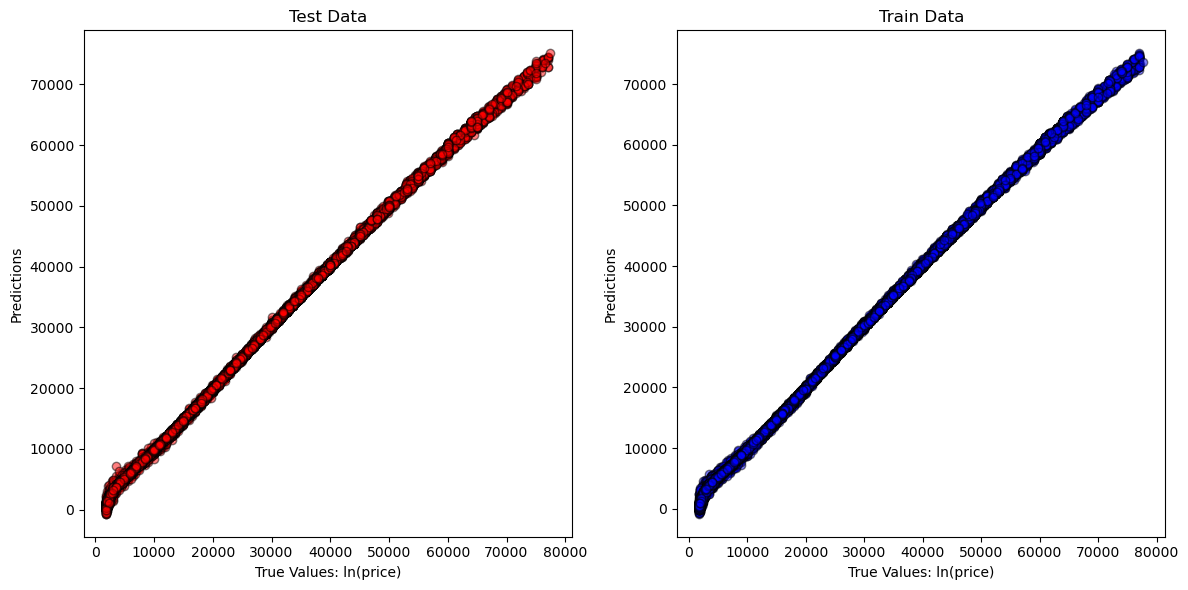

In [665]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

# Plot for test data
axs[0].scatter(y_test, pipe.predict(X_test), c='red', alpha=0.5, edgecolors='black')
axs[0].set_xlabel('True Values: ln(price)')
axs[0].set_ylabel('Predictions')
axs[0].set_title('Test Data')

# Plot for train data
axs[1].scatter(y_train, pipe.predict(X_train), c='blue', alpha=0.5, edgecolors='black')
axs[1].set_xlabel('True Values: ln(price)')
axs[1].set_ylabel('Predictions')
axs[1].set_title('Train Data')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Lasso Regression model

After conducting Linear Regression analysis, I proceeded to assess another regression method known as the LASSO model.

To optimize the LASSO model, I employed GridSearchCV. The evaluation metric chosen for optimization was the minimum mean squared error (neg_mean_squared_error), utilizing a 3-fold cross-validation strategy. The hyperparameter under consideration for optimization was the alpha coefficient of the LASSO regressor

In [683]:
X = cars_encoded.drop('price', axis = 1)
y_log = cars_encoded['price_log']
y = cars_encoded['price']

In [684]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .3)

In [687]:
#Dictionary of alpha values for GridSearchCV
alphas = {"lasso__alpha" : [0.0001,100.0]}

In [688]:
#Defining the pipeline (polynominal 3 + scaler + LASSO)
lasso_pipe = Pipeline([
    ("poly", PolynomialFeatures(degree = 3, include_bias = False)),
    ("scaler", StandardScaler()),
    ("lasso", Lasso())
])

In [689]:
#GridSearchCV to find optimal alpha
lasso_grid = GridSearchCV(estimator = lasso_pipe,
                            param_grid = alphas,
                            scoring = "neg_mean_squared_error",
                            cv = 3)   

In [ ]:
lasso_grid.fit(X, y)